In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Step 1: Install kaggle CLI if not already
!pip install -q kaggle

# Step 2: Upload the correct kaggle.json file
from google.colab import files
uploaded = files.upload()  # ← make sure you upload your real kaggle.json here

Saving kaggle.json to kaggle (3).json


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import shutil
import os

# Replace with correct path after using os.listdir()
source_path = "/content/kaggle.json"
target_path = os.path.expanduser("~/.kaggle/kaggle.json")

os.makedirs(os.path.dirname(target_path), exist_ok=True)
shutil.copy(source_path, target_path)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/diabetic-retinopathy-resized


100%|██████████| 35108/35108 [41:16<00:00, 14.18it/s]


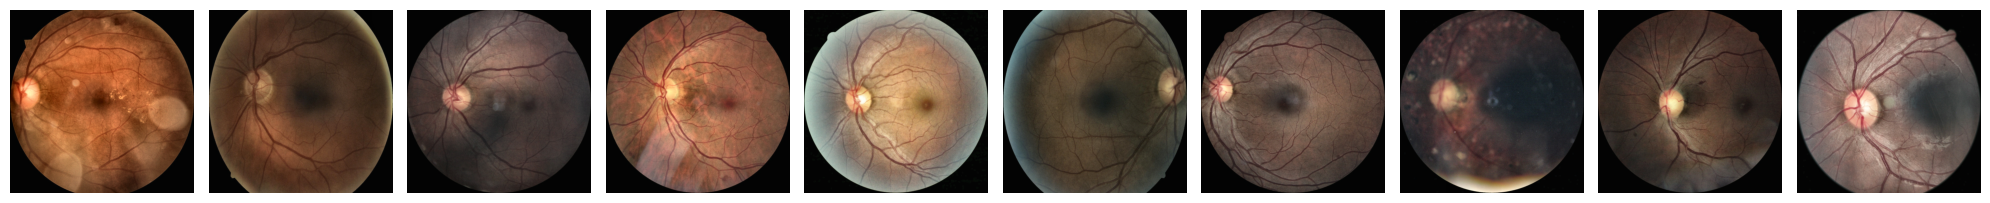


✅ Done! Preprocessed images saved to: /content/drive/MyDrive/EECE 490 Project/EyePac/Cleaned_images | Skipped 11118 bad images.


In [ ]:
# === Imports ===
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import shutil

# === Black Border Remover ===
def remove_black_border(img, threshold=5):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return img[y:y+h, x:x+w]

# === Auto Flip if Left Eye ===
def auto_flip_if_left_eye(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    left = np.mean(gray[:, :w//2])
    right = np.mean(gray[:, w//2:])
    if right > left:
        return cv2.flip(img, 1)  # horizontal flip
    return img

# === Full Preprocessing Pipeline (Resizing moved to end) ===
def preprocess_image_full(img, target_size=(512, 512), blur_thresh=20.0, brightness_thresh=25):
    try:
        if img is None or len(img.shape) != 3 or img.shape[2] != 3:
            return None

        # Blur and brightness checks
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if cv2.Laplacian(gray, cv2.CV_64F).var() < blur_thresh:
            return None
        if np.mean(gray) < brightness_thresh:
            return None

        # Remove black borders
        img = remove_black_border(img)

        # Auto flip if left eye
        img = auto_flip_if_left_eye(img)

        # CLAHE enhancement
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

        # Glare detection
        glare_mask = cv2.inRange(img, (240, 240, 240), (255, 255, 255))
        contours, _ = cv2.findContours(glare_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if any(cv2.contourArea(c) > 500 for c in contours):
            return None

        # Text/annotation filter
        mask_text = cv2.inRange(img, (220, 220, 220), (255, 255, 255))
        if cv2.countNonZero(mask_text) > 3000:
            return None

        # Dark region filter
        if np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) > 10) < 0.2:
            return None

        # ✅ Resize (critical fix)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

        # ✅ Validate shape before return
        if img.shape != (512, 512, 3):
            raise ValueError(f"Resized image has invalid shape: {img.shape}")

        # Normalize to [-1, 1]
        return img.astype(np.float32) / 127.5 - 1.0

    except Exception as e:
        print(f"⚠️ Exception during processing: {e}")
        return None

# === Set Input/Output Folders ===
# Modify the path as needed for your local or Colab environment
base_path = "/content/drive/MyDrive/EECE 490 Project/EyePac"
input_folder = os.path.join(path, "resized_train_cropped", "resized_train_cropped")
output_folder = os.path.join(base_path, "Cleaned_images")
os.makedirs(output_folder, exist_ok=True)

# === Run Preprocessing ===
skipped = []
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
sample_images = []

for fname in tqdm(image_files):
    in_path = os.path.join(input_folder, fname)
    out_path = os.path.join(output_folder, fname)

    img = cv2.imread(in_path)
    if img is None:
        skipped.append(fname)
        continue

    processed = preprocess_image_full(img)
    if processed is None:
        skipped.append(fname)
        continue
    if processed.shape != (512, 512, 3):
        print(f"⚠️ Unexpected size in {fname}: {processed.shape}")
        skipped.append(fname)
        continue

    out_img = ((processed + 1.0) * 127.5).astype(np.uint8)
    cv2.imwrite(out_path, out_img)

    if len(sample_images) < 10 and random.random() < 0.1:
        sample_images.append(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

# === Show Random Previews ===
if sample_images:
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(sample_images):
        plt.subplot(1, len(sample_images), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No sample images to display.")

print(f"\n✅ Done! Preprocessed images saved to: {output_folder} | Skipped {len(skipped)} bad images.")


In [ ]:
import os
import cv2

# === Folder containing images ===
folder_path = "/content/drive/MyDrive/EECE 490 Project/EyePac/Cleaned_images"

# === Loop through all files and check dimensions ===
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Could not read {filename}")
            continue

        h, w = img.shape[:2]
        if h != 512 or w != 512:
            print(f"⚠️ {filename} has size {w}x{h}")


In [ ]:
cleaned_images = [f for f in os.listdir(output_folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
print(f"🧼 Number of cleaned images: {len(cleaned_images)}")


🧼 Number of cleaned images: 23990


In [ ]:
import os
import pandas as pd

# === Paths ===
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")
labels_path = os.path.join(path, "trainLabels_cropped.csv")
df = pd.read_csv(labels_path)

# === Load CSV and add filename column ===
df['filename'] = df['image'].astype(str) + ".jpeg"

# === Get filenames of kept images ===
kept_images = set(os.listdir(output_folder))

# === Filter CSV based on kept images ===
df_filtered = df[df['filename'].isin(kept_images)]

# === Count and display label distribution ===
label_counts = df_filtered['level'].value_counts().sort_index()
count_0 = label_counts.get(0, 0)
count_1 = label_counts.get(1, 0)
count_2 = label_counts.get(2, 0)
count_3 = label_counts.get(3, 0)
count_4 = label_counts.get(4, 0)

print(f"✅ Remaining samples:\n  No_DR (0): {count_0}\n  DR (1): {count_1}\n  DR (2): {count_2}\n  DR (3): {count_3}\n  DR (4): {count_4}")

# === Save the filtered CSV ===
output_csv_path = "/content/drive/MyDrive/EECE 490 Project/EyePac/trainLabels_filtered.csv"
df_filtered.to_csv(output_csv_path, index=False)

print(f"\n📁 Filtered CSV saved to: {output_csv_path}")


✅ Remaining samples:
  No_DR (0): 17655
  DR (1): 1810
  DR (2): 3529
  DR (3): 593
  DR (4): 403

📁 Filtered CSV saved to: /content/drive/MyDrive/EECE 490 Project/EyePac/trainLabels_filtered.csv


In [ ]:
import os
import pandas as pd
import shutil

# === Paths ===
base_dir = "/content/drive/MyDrive/EECE 490 Project/EyePac"
input_csv = os.path.join(base_dir, "trainLabels_filtered.csv")
input_images_folder = os.path.join(base_dir, "Cleaned_images")
output_csv = os.path.join(base_dir, "trainLabels_filtered_unbalanced.csv")
output_split_folder = os.path.join(base_dir, "Unbalanced_Split")
no_dr_folder = os.path.join(output_split_folder, "NoDR")
dr_folder = os.path.join(output_split_folder, "DR")

# === Step 1: Load CSV and add binary_level column ===
df = pd.read_csv(input_csv)
df["binary_level"] = df["level"].apply(lambda x: 0 if x == 0 else 1)

# === Step 2: Save new CSV file ===
df.to_csv(output_csv, index=False)
print(f"✅ New CSV file saved to: {output_csv}")

# === Step 3: Create output folders ===
os.makedirs(no_dr_folder, exist_ok=True)
os.makedirs(dr_folder, exist_ok=True)

# === Step 4: Copy images based on binary_level ===
for _, row in df.iterrows():
    fname = row["filename"]
    label = row["binary_level"]

    src_path = os.path.join(input_images_folder, fname)
    dst_path = os.path.join(no_dr_folder if label == 0 else dr_folder, fname)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print(f"✅ Images split into {no_dr_folder} and {dr_folder} based on binary labels.")


✅ New CSV file saved to: /content/drive/MyDrive/EECE 490 Project/EyePac/trainLabels_filtered_unbalanced.csv
✅ Images split into /content/drive/MyDrive/EECE 490 Project/EyePac/Unbalanced_Split/NoDR and /content/drive/MyDrive/EECE 490 Project/EyePac/Unbalanced_Split/DR based on binary labels.


In [ ]:
import os
import pandas as pd
import shutil

# === Paths ===
filtered_csv_path = "/content/drive/MyDrive/EECE 490 Project/EyePac/trainLabels_filtered.csv"
output_folder = "/content/drive/MyDrive/EECE 490 Project/EyePac/Cleaned_images"
balanced_csv_path = "/content/drive/MyDrive/EECE 490 Project/EyePac/trainLabels_balanced.csv"
balanced_images_folder = "/content/drive/MyDrive/EECE 490 Project/EyePac/Balanced_Images"
os.makedirs(balanced_images_folder, exist_ok=True)

# === Load filtered CSV ===
df_filtered = pd.read_csv(filtered_csv_path)

# === Add binary label column ===
df_filtered['binary_level'] = df_filtered['level'].apply(lambda x: 0 if x == 0 else 1)

# === Balance the dataset ===
min_count = df_filtered['binary_level'].value_counts().min()
df_balanced = pd.concat([
    df_filtered[df_filtered['binary_level'] == 0].sample(min_count, random_state=42),
    df_filtered[df_filtered['binary_level'] == 1].sample(min_count, random_state=42)
]).reset_index(drop=True)

# === Save balanced CSV ===
df_balanced.to_csv(balanced_csv_path, index=False)
print(f"✅ Balanced CSV saved to: {balanced_csv_path}")

# === Copy images to Balanced_Images folder ===
for fname in df_balanced['filename']:
    src = os.path.join(output_folder, fname)
    dst = os.path.join(balanced_images_folder, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)

print(f"✅ {len(df_balanced)} images copied to: {balanced_images_folder}")


✅ Balanced CSV saved to: /content/drive/MyDrive/EECE 490 Project/EyePac/trainLabels_balanced.csv
✅ 12670 images copied to: /content/drive/MyDrive/EECE 490 Project/EyePac/Balanced_Images


In [ ]:
# === Count binary label distribution in balanced dataset ===
binary_counts = df_balanced['binary_level'].value_counts().sort_index()
count_0 = binary_counts.get(0, 0)
count_1 = binary_counts.get(1, 0)

print(f"📊 Class Distribution in Balanced CSV:\n  No_DR (0): {count_0}\n  DR (1): {count_1}")


📊 Class Distribution in Balanced CSV:
  No_DR (0): 6335
  DR (1): 6335


In [ ]:
import os
import pandas as pd
import shutil

# === Paths ===
balanced_csv_path = "/content/drive/MyDrive/EECE 490 Project/EyePac/trainLabels_balanced.csv"
balanced_images_folder = "/content/drive/MyDrive/EECE 490 Project/EyePac/Balanced_Images"
split_folder = "/content/drive/MyDrive/EECE 490 Project/EyePac/Balanced_Split"
dr_folder = os.path.join(split_folder, "DR")
no_dr_folder = os.path.join(split_folder, "NoDR")

# === Create target folders ===
os.makedirs(dr_folder, exist_ok=True)
os.makedirs(no_dr_folder, exist_ok=True)

# === Load balanced CSV ===
df_balanced = pd.read_csv(balanced_csv_path)

# === Copy images to corresponding folders ===
for _, row in df_balanced.iterrows():
    fname = row['filename']
    label = row['binary_level']

    src = os.path.join(balanced_images_folder, fname)
    dst = os.path.join(dr_folder if label == 1 else no_dr_folder, fname)

    if os.path.exists(src):
        shutil.copy(src, dst)

print("✅ Images split into DR and NoDR folders successfully!")


✅ Images split into DR and NoDR folders successfully!
